#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import warnings
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import joblib

In [3]:
warnings.filterwarnings('ignore')

### (2) 데이터 불러오기 - 구글 드라이브 연동

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 안나누고

### (1) 데이터 불러오기

In [24]:
FOLDER_PATH = '/content/drive/MyDrive/에이블/미니프로젝트5차_3~5일차/Kaggle'

In [25]:
data = pd.read_csv(os.path.join(FOLDER_PATH, 'train.csv'))
data.drop('timestamp', axis=1, inplace=True)

In [26]:
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [27]:
data.head()

,ID,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8
1,1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
2,2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
3,3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
4,4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6


### (2) 데이터 전처리

In [28]:
# 결측치 평균값으로
data.fillna(data.mean(), inplace=True)
nan_counts = data.isna().sum()
nan_counts

ID       0
A_x      0
A_y      0
A_z      0
B_x      0
B_y      0
B_z      0
label    0
dtype: int64

In [29]:
target = 'label'
x = data.drop(target, axis=1)
y = data[target]

In [30]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

encoder = LabelEncoder()
y_en = encoder.fit_transform(y)

In [31]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y_en, test_size=0.2, stratify=y_en,  random_state=42)
train_x_s, valid_x_s, train_y, valid_y = train_test_split(x_s, y_en, test_size=0.2, stratify=y_en,  random_state=42)
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape)
print(train_x_s.shape, valid_x_s.shape, train_y.shape, valid_y.shape)

(80000, 7) (20000, 7) (80000,) (20000,)
(80000, 7) (20000, 7) (80000,) (20000,)


### (3) 데이터 모델링

In [32]:
# Random Forest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model_RF=RandomForestClassifier(random_state=42)
model_RF.fit(train_x, train_y)
print(model_RF.score(valid_x, valid_y))


0.8587


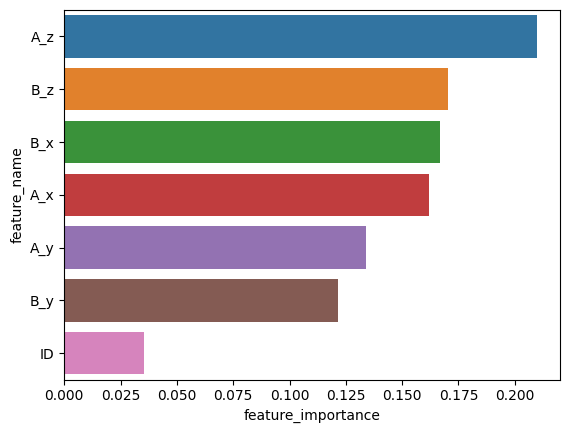

In [33]:
data_rf = pd.DataFrame({'feature_name':model_RF.feature_names_in_,'feature_importance':model_RF.feature_importances_})
data_rf.sort_values(by=['feature_importance'], ascending=False,inplace=True)
data_rf.reset_index(inplace=True)
data_rf = data_rf.head(200)
sns.barplot(x='feature_importance', y='feature_name', data=data_rf.head(20))
plt.show()

### (4) test파일

In [34]:
def pipeline(cur_data):
    # 1. cur_data에서 먼저 0,1로 분류하기
    pred_first = model_RF.predict(cur_data)
    print(classification_report(pred_first, y2_test))
    print(confusion_matrix(pred_first, y2_test))

    # 2. 원본 데이터에 예측결과 합치기
    cur_data['pred_first']=pred_first
    index_list = cur_data.index.tolist()

    # 3. 예측값을 0, 1인 경우로 분류해서 데이터 나누기
    cur_data_0 = cur_data[cur_data['pred_first']==0]
    cur_data_1 = cur_data[cur_data['pred_first']==1]

    # 4. 분리한 데이터에서 다시 칼럼 삭제
    cur_data_0.drop(columns=['pred_first'], axis=1, inplace=True)
    cur_data_1.drop(columns=['pred_first'], axis=1, inplace=True)

    # 5. 각각의 0, 1의 모델에 데이터 넣기
    pred_j = model_j.predict(cur_data_0)
    pred_d = model_d.predict(cur_data_1)

    # 6. 분리한 데이터에 예측결과 합치기
    cur_data_0['pred']=pred_j
    cur_data_1['pred']=pred_d

    # 7. 두 데이터 프레임 합치고 인덱스 순서대로 정렬
    result = pd.concat([cur_data_0, cur_data_1])
    result1 = result.loc[index_list]

    # 8. pred 칼럼만 추출해 예측 결과 빼내기
    answer=result1['pred']
    return answer


In [42]:
test = pd.read_csv(os.path.join(FOLDER_PATH, 'test.csv'))
test.drop('timestamp', axis=1, inplace=True)

In [43]:
test.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [44]:
test.head()

,ID,A_x,A_y,A_z,B_x,B_y,B_z
0,0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673
1,1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270
2,2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689
3,3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534
4,4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614


In [45]:
predictions = model_RF.predict(test)

test['label'] = predictions+1

In [48]:
test['label'].head()

0     6
1     4
2    11
3     9
4     7
Name: label, dtype: int64

In [49]:
test[['ID', 'label']].to_csv('predicted_labels_notdivided.csv', index=False)

## 동적.정적 나눠서

### (1) 데이터 불러오기

In [200]:
FOLDER_PATH = '/content/drive/MyDrive/에이블/미니프로젝트5차_3~5일차/Kaggle'

In [201]:
data = pd.read_csv(os.path.join(FOLDER_PATH, 'train.csv'))

In [202]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day

In [203]:
data = data.drop('timestamp', axis=1)

In [204]:
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [205]:
data.head()

,ID,A_x,A_y,A_z,B_x,B_y,B_z,label,year,month,day
0,0,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8,2019,1,12
1,1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2,2000,1,1
2,2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8,2019,1,12
3,3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11,2000,1,1
4,4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6,2000,1,1


In [206]:
test = pd.read_csv(os.path.join(FOLDER_PATH, 'test.csv'))

In [207]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day

In [208]:
test.drop('timestamp', axis=1, inplace=True)

In [209]:
test.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [210]:
test.head()

,ID,A_x,A_y,A_z,B_x,B_y,B_z,year,month,day
0,0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673,2000,1,1
1,1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270,2000,1,1
2,2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689,2000,1,1
3,3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534,2019,1,12
4,4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614,2019,1,12


### (2) 데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

1: 걷기

2: 뛰기

3: 천천히 걷기

4: 계단 오르기

5: 계단 내려가기

6: 서있기

7: 앉아있기

8: 누워있기

9: 자전거 타기

10: 서서 자전거 타기

11: 자전거에 앉아있기

In [211]:
# 결측치 평균값으로
data.fillna(data.mean(), inplace=True)
nan_counts = data.isna().sum()
nan_counts

ID       0
A_x      0
A_y      0
A_z      0
B_x      0
B_y      0
B_z      0
label    0
year     0
month    0
day      0
dtype: int64

In [212]:
def convert_label_to_dynamic(label):
    if label in [6,7,8,11]: # 정적
        return 0
    elif label in [1,2,3,4,5,9,10]: # 동적
        return 1
data['label_dynamic'] = data['label'].apply(convert_label_to_dynamic)
data['label_dynamic'].value_counts()

1    63420
0    36580
Name: label_dynamic, dtype: int64

In [214]:
target1 = 'label'
target2 = 'label_dynamic'

x = data.drop([target1, target2], axis = 1)
y1 = data[target1]
y2 = data[target2]


In [215]:
# train, val, test 데이터로 데이터를 분리
from sklearn.model_selection import train_test_split
x_train, x_val, y1_train, y1_val, y2_train, y2_val = train_test_split(x, y1, y2, test_size=0.2, random_state=1)
x_train, x_test, y1_train, y1_test, y2_train, y2_test = train_test_split(x_train, y1_train, y2_train, test_size=0.2, random_state=1)

### **(3) 단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### 3-(1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : RandomForestClassifier

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7182
           1       0.98      0.97      0.98     12818

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[ 6959   223]
 [  365 12453]]


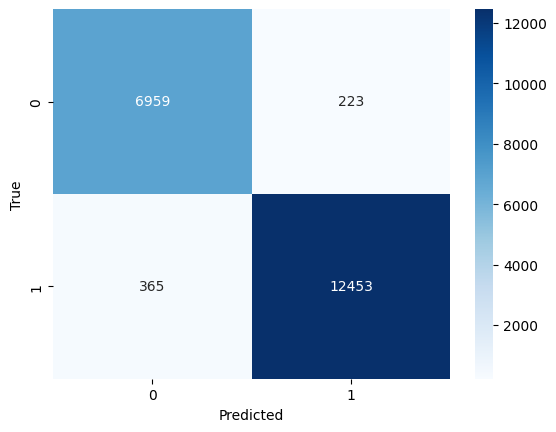

In [216]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model1=RandomForestClassifier()
model1.fit(x_train, y2_train)
y_pred1=model1.predict(x_val)

print(classification_report(y_pred1, y2_val))
conf_matrix = confusion_matrix(y_pred1, y2_val)
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 2) 알고리즘2 : XGB

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7324
           1       0.98      0.98      0.98     12676

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[ 7047   277]
 [  262 12414]]


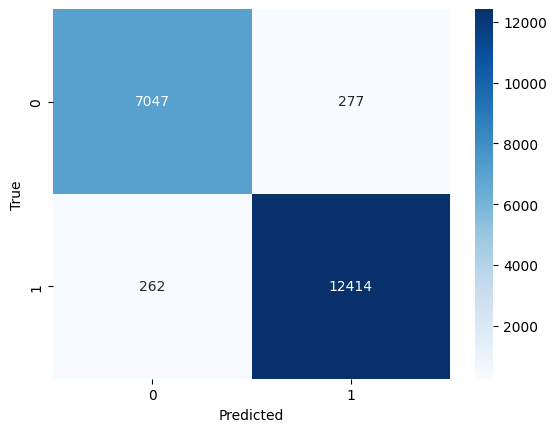

In [217]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model2 = XGBClassifier()
model2.fit(x_train, y2_train)

y_pred2 = model2.predict(x_val)

print(classification_report(y2_val, y_pred2))
conf_matrix = confusion_matrix(y2_val, y_pred2)
print(conf_matrix)

# 혼동 행렬 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 3) 알고리즘3 : KNN

              precision    recall  f1-score   support

           0       0.63      0.53      0.58      7324
           1       0.75      0.82      0.78     12676

    accuracy                           0.71     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.71      0.71      0.71     20000

[[ 3905  3419]
 [ 2295 10381]]


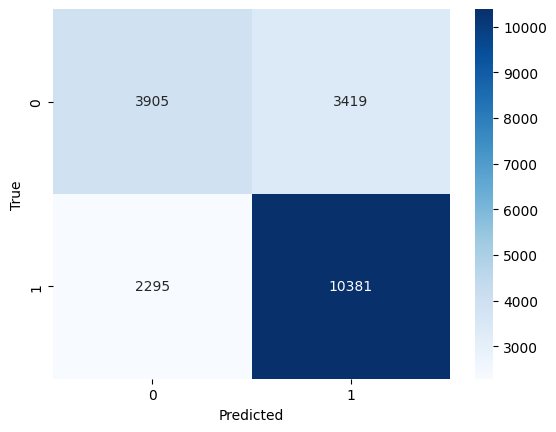

In [218]:
model3 = KNeighborsClassifier(n_neighbors=5)
model3.fit(x_train, y2_train)

y_pred3 = model3.predict(x_val)

print(classification_report(y2_val, y_pred3))

conf_matrix = confusion_matrix(y2_val, y_pred3)
print(conf_matrix)

# 혼동 행렬 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [219]:
# XGB y_pred값을 test['label']로 저장
y_pred2 = y_pred2[:13234]
test['label'] = y_pred2

In [220]:
test.tail()

,ID,A_x,A_y,A_z,B_x,B_y,B_z,year,month,day,label
13229,13229,-1.379061,0.070504,-0.528339,-1.154145,0.097546,-0.537505,2000,1,1,0
13230,13230,-1.039895,-0.122421,0.065954,-1.152930,0.294010,1.080373,2019,1,12,0
13231,13231,-1.176883,-0.218801,-0.581625,-0.809665,0.126385,0.314077,2000,1,1,1
13232,13232,-0.912287,-0.148846,-0.141693,-1.382983,0.102818,0.933066,2000,1,1,0
13233,13233,-1.015306,-0.013448,-0.171994,-0.087205,-0.289400,0.943548,2019,1,12,0


### 3-(2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [221]:
static_data = data[data['label'].isin([6,7,8,11])]
static_data.drop(target2, axis=1, inplace=True)
def classify_static_label(label):
    if label == 6: # 서있기
        return 0
    elif label == 7: # 앉아있기
        return 1
    elif label == 8: # 누워있기
        return 2
    else: # 11. 자전거에 앉아있기
        return 3
static_data['label_Type'] = data['label'].apply(classify_static_label)
static_data['label_Type'].value_counts()

2    11497
1    10594
3     9112
0     5377
Name: label_Type, dtype: int64

In [222]:
target1 = 'label'
target2 = 'label_Type'

x = static_data.drop([target1, target2], axis = 1)
y1 = static_data[target1]
y2 = static_data[target2]

train_x, valid_x, train_y1, valid_y1, train_y2, valid_y2 = train_test_split(x, y1, y2, test_size=0.2, stratify=y2, random_state=42)
print(train_x.shape, valid_x.shape, train_y1.shape, valid_y1.shape, train_y2.shape, valid_y2.shape)

(29264, 10) (7316, 10) (29264,) (7316,) (29264,) (7316,)


0.9881082558775287
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      1076
           1       1.00      1.00      1.00      2119
           2       1.00      1.00      1.00      2299
           3       0.97      0.99      0.98      1822

    accuracy                           0.99      7316
   macro avg       0.99      0.98      0.98      7316
weighted avg       0.99      0.99      0.99      7316

Confusion Matrix:
 [[1018    0    0   58]
 [   0 2118    1    0]
 [   0    4 2295    0]
 [  24    0    0 1798]]


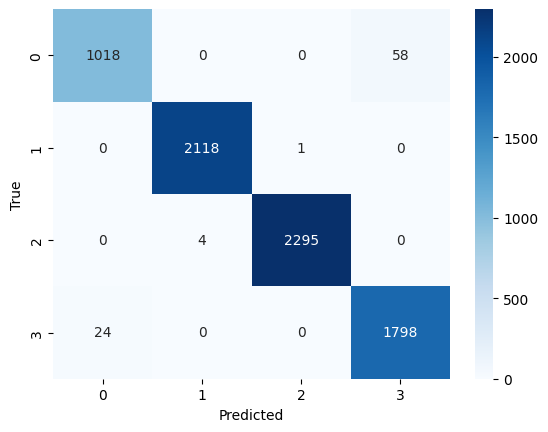

In [223]:
# RandomForest
RF_static_type_model = RandomForestClassifier(random_state=42)
RF_static_type_model.fit(train_x, train_y2)
print(RF_static_type_model.score(valid_x, valid_y2))

y_pred_RF_static = RF_static_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_RF_static))

# confusion_matrix 출력
conf_matrix = confusion_matrix(valid_y2, y_pred_RF_static)
print("Confusion Matrix:\n", conf_matrix)

# 혼동 행렬 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

0.9882449425915801
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1076
           1       1.00      1.00      1.00      2119
           2       1.00      1.00      1.00      2299
           3       0.97      0.98      0.98      1822

    accuracy                           0.99      7316
   macro avg       0.99      0.98      0.98      7316
weighted avg       0.99      0.99      0.99      7316

Confusion Matrix:
 [[1027    0    0   49]
 [   0 2118    1    0]
 [   0    4 2295    0]
 [  32    0    0 1790]]


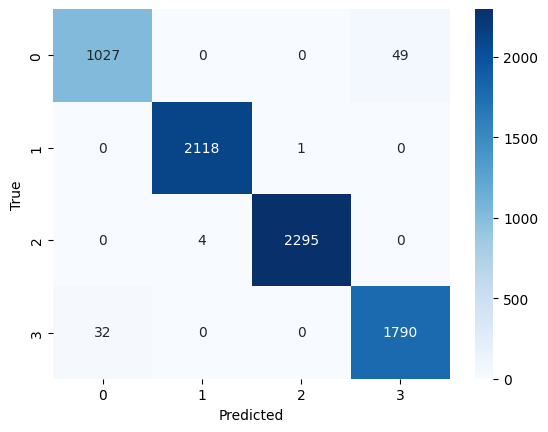

In [224]:
# XGB
XGB_static_type_model = XGBClassifier(random_state=42)
XGB_static_type_model.fit(train_x, train_y2)
print(XGB_static_type_model.score(valid_x, valid_y2))

y_pred_XGB = XGB_static_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_XGB))

# confusion_matrix 출력
conf_matrix = confusion_matrix(valid_y2, y_pred_XGB)
print("Confusion Matrix:\n", conf_matrix)

# 혼동 행렬 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

0.48455440131219246
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.29      0.31      1076
           1       0.44      0.46      0.45      2119
           2       0.48      0.52      0.50      2299
           3       0.62      0.59      0.61      1822

    accuracy                           0.48      7316
   macro avg       0.47      0.46      0.47      7316
weighted avg       0.48      0.48      0.48      7316

Confusion Matrix:
 [[ 310   65   71  630]
 [   8  975 1132    4]
 [   9 1091 1187   12]
 [ 567   90   92 1073]]


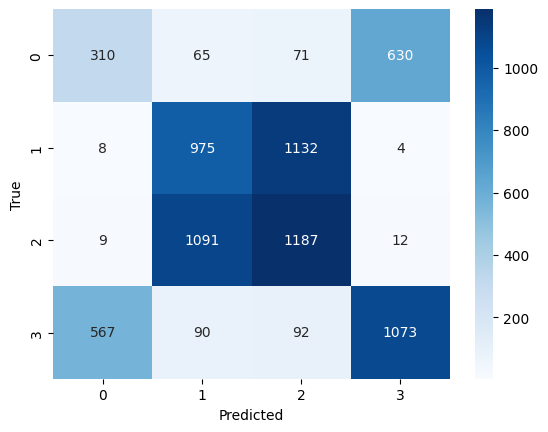

In [225]:
# KNN
KNN_static_type_model = KNeighborsClassifier(n_neighbors=5)
KNN_static_type_model.fit(train_x, train_y2)
print(KNN_static_type_model.score(valid_x, valid_y2))

y_pred_KNN = KNN_static_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_KNN))

# confusion_matrix 출력
conf_matrix = confusion_matrix(valid_y2, y_pred_KNN)
print("Confusion Matrix:\n", conf_matrix)

# 혼동 행렬 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 3-(3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [226]:
dynamic_data = data[data['label'].isin([1,2,3,4,5,9,10])]
# 1: 걷기 2: 뛰기 3: 천천히 걷기 4: 계단 오르기 5: 계단 내려가기 9: 자전거 타기 10: 서서 자전거 타기
dynamic_data.drop('label_dynamic', axis=1, inplace=True)
def classify_dynamic_label(label):
    if label == 1: # 1: 걷기
        return 0
    elif label == 2: # 2: 뛰기
        return 1
    elif label == 3: # 3: 천천히 걷기
        return 2
    elif label == 4: # 4: 계단 오르기
        return 3
    elif label == 5: # 5: 계단 내려가기
        return 4
    elif label == 9: # 9: 자전거 타기
        return 5
    else: # 10: 서서 자전거 타기
        return 6
dynamic_data['label_Type'] = data['label'].apply(classify_dynamic_label)
dynamic_data['label_Type'].value_counts()

1    12170
0    11465
6     9579
5     9282
2     8305
3     7208
4     5411
Name: label_Type, dtype: int64

In [227]:
target1 = 'label'
target2 = 'label_Type'

x = dynamic_data.drop([target1, target2], axis = 1)
y1 = dynamic_data[target1]
y2 = dynamic_data[target2]

train_x, valid_x, train_y1, valid_y1, train_y2, valid_y2 = train_test_split(x, y1, y2, test_size=0.2, stratify=y2, random_state=42)
print(train_x.shape, valid_x.shape, train_y1.shape, valid_y1.shape, train_y2.shape, valid_y2.shape)

(50736, 10) (12684, 10) (50736,) (12684,) (50736,) (12684,)


In [228]:
# RandomForest
RF_dynamic_type_model = RandomForestClassifier(random_state=42)
RF_dynamic_type_model.fit(train_x, train_y2)
print(RF_dynamic_type_model.score(valid_x, valid_y2))

y_pred_RF_dynamic = RF_dynamic_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_RF_dynamic))

0.8290760012614318
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      2293
           1       0.89      0.86      0.88      2434
           2       0.78      0.72      0.75      1661
           3       0.77      0.80      0.78      1442
           4       0.62      0.52      0.56      1082
           5       1.00      1.00      1.00      1856
           6       0.89      0.91      0.90      1916

    accuracy                           0.83     12684
   macro avg       0.81      0.81      0.81     12684
weighted avg       0.83      0.83      0.83     12684



In [229]:
# XGB
XGB_dynamic_type_model = XGBClassifier(random_state=42)
XGB_dynamic_type_model.fit(train_x, train_y2)
print(XGB_dynamic_type_model.score(valid_x, valid_y2))

y_pred_XGB_dynamic = XGB_dynamic_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_XGB_dynamic))

0.82639545884579
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      2293
           1       0.90      0.86      0.88      2434
           2       0.75      0.72      0.73      1661
           3       0.77      0.79      0.78      1442
           4       0.61      0.52      0.56      1082
           5       1.00      1.00      1.00      1856
           6       0.89      0.90      0.90      1916

    accuracy                           0.83     12684
   macro avg       0.81      0.80      0.80     12684
weighted avg       0.83      0.83      0.83     12684



In [230]:
# KNN
KNN_dynamic_type_model = KNeighborsClassifier(n_neighbors=5)
KNN_dynamic_type_model.fit(train_x, train_y2)
print(KNN_dynamic_type_model.score(valid_x, valid_y2))

y_pred_KNN_dynamic = KNN_dynamic_type_model.predict(valid_x)
print("Classification Report:\n", classification_report(valid_y2, y_pred_KNN_dynamic))

0.2781456953642384
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.38      0.27      2293
           1       0.22      0.24      0.23      2434
           2       0.14      0.13      0.14      1661
           3       0.12      0.09      0.10      1442
           4       0.08      0.04      0.06      1082
           5       1.00      0.78      0.87      1856
           6       0.17      0.12      0.14      1916

    accuracy                           0.28     12684
   macro avg       0.28      0.25      0.26     12684
weighted avg       0.29      0.28      0.28     12684



static data는 XBG의 예측값  
dynamic data는 random forest 예측값 사용해야할듯

In [231]:
# 예측 결과를 'label' 열에 설정
for i in range(len(test)):
    if i < len(y_pred_RF_static):
        test.loc[i, 'label'] = y_pred_RF_static[i]
    else:
        test.loc[i, 'label'] = y_pred_RF_dynamic[i - len(y_pred_RF_static)]


In [232]:
test.tail()

,ID,A_x,A_y,A_z,B_x,B_y,B_z,year,month,day,label
13229,13229,-1.379061,0.070504,-0.528339,-1.154145,0.097546,-0.537505,2000,1,1,2
13230,13230,-1.039895,-0.122421,0.065954,-1.152930,0.294010,1.080373,2019,1,12,1
13231,13231,-1.176883,-0.218801,-0.581625,-0.809665,0.126385,0.314077,2000,1,1,1
13232,13232,-0.912287,-0.148846,-0.141693,-1.382983,0.102818,0.933066,2000,1,1,6
13233,13233,-1.015306,-0.013448,-0.171994,-0.087205,-0.289400,0.943548,2019,1,12,2


In [233]:
test[['ID', 'label']].to_csv('predicted_labels_divided.csv', index=False)

### 3-(4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [52]:
class labelClassifier:

    def __label_to_dynamic(self, label):
        if label in [6,7,8,11]:
            return 0
        elif label in [1,2,3,4,5,9,10]:
            return 1

    def __classify_static_label(self, label):
        if label == 6: # 서있기
            return 0
        elif label == 7: # 앉아있기
            return 1
        elif label == 8: # 누워있기
            return 2
        else: # 11. 자전거에 앉아있기
            return 3

    def __classify_dynamic_label(self, label):
        if label == 1: # 1: 걷기
            return 0
        elif label == 2: # 2: 뛰기
            return 1
        elif label == 3: # 3: 천천히 걷기
            return 2
        elif label == 4: # 4: 계단 오르기
            return 3
        elif label == 5: # 5: 계단 내려가기
            return 4
        elif label == 9: # 9: 자전거 타기
            return 5
        else: # 10: 서서 자전거 타기
            return 6

    def __read_static(self, num):
        if num == 0:
            return 'LAYING'
        elif num == 1:
            return 'SITTING'
        else:
            return 'STANDING'

    def __read_dynamic(self, num):
        if num == 0:
            return 'WALKING'
        elif num == 1:
            return 'WALKING_UPSTAIRS'
        else:
            return 'WALKING_DOWNSTAIRS'

    def __init__(self, is_dynamic_models, static_type_models, dynamic_type_models, feature_limit=0):
        self.feature_limit = feature_limit

        self.is_dynamic_models = list()
        self.static_type_models = list()
        self.dynamic_type_models = list()

        self.is_dynamic_models.extend(is_dynamic_models),
        self.static_type_models.extend(static_type_models),
        self.dynamic_type_models.extend(dynamic_type_models)

    def get_feature_importances(self, train_x, train_y):
        x1 = train_x
        y1 = train_y.apply(self.__activity_to_dynamic)

        train = x1.copy()
        train['Avtivity'] = train_y

        train_static = train[train['Avtivity'].isin(['STANDING', 'SITTING', 'LAYING'])]
        x2 = train_static.drop('Avtivity', axis = 1)
        y2 = train_static['Avtivity'].apply(self.__classify_static_activity)

        train_dynamic = train[train['Avtivity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]
        x3 = train_dynamic.drop('Avtivity', axis = 1)
        y3 = train_dynamic['Avtivity'].apply(self.__classify_dynamic_activity)

        self.is_dynamic_features = list()
        self.static_type_features = list()
        self.dynamic_type_features = list()

        temp_features = pd.DataFrame()
        for i, is_dynamic_model in enumerate(self.is_dynamic_models):
            is_dynamic_model.fit(x1, y1)
            if self.feature_limit > 0:
                temp_features = pd.DataFrame({'feature_name':is_dynamic_model.feature_names_in_,
                                            'feature_importance':is_dynamic_model.feature_importances_})
                temp_features.sort_values(by=['feature_importance'], ascending=False, inplace=True)
                self.is_dynamic_features.append(temp_features.head(self.feature_limit)['feature_name'].to_list())

        print('is_dynamic_models feature importances done')

        for i, static_type_model in enumerate(self.static_type_models):
            static_type_model.fit(x2, y2)
            if self.feature_limit > 0:
                temp_features = pd.DataFrame({'feature_name':static_type_model.feature_names_in_,
                                            'feature_importance':static_type_model.feature_importances_})
                temp_features.sort_values(by=['feature_importance'], ascending=False, inplace=True)
                self.static_type_features.append(temp_features.head(self.feature_limit)['feature_name'].to_list())

        print('static_type_models feature importances done')

        for i, dynamic_type_model in enumerate(self.dynamic_type_models):
            dynamic_type_model.fit(x3, y3)
            if self.feature_limit > 0:
                temp_features = pd.DataFrame({'feature_name':dynamic_type_model.feature_names_in_,
                                            'feature_importance':dynamic_type_model.feature_importances_})
                temp_features.sort_values(by=['feature_importance'], ascending=False, inplace=True)
                self.dynamic_type_features.append(temp_features.head(self.feature_limit)['feature_name'].to_list())

        print('dynamic_type_models feature importances done')

    def fit(self, train_x, train_y):

        x1 = train_x
        y1 = train_y.apply(self.__activity_to_dynamic)

        train = x1.copy()
        train['Avtivity'] = train_y

        train_static = train[train['Avtivity'].isin(['STANDING', 'SITTING', 'LAYING'])]
        x2 = train_static.drop('Avtivity', axis = 1)
        y2 = train_static['Avtivity'].apply(self.__classify_static_activity)

        train_dynamic = train[train['Avtivity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]
        x3 = train_dynamic.drop('Avtivity', axis = 1)
        y3 = train_dynamic['Avtivity'].apply(self.__classify_dynamic_activity)

        for i, is_dynamic_model in enumerate(self.is_dynamic_models):
            if self.feature_limit > 0:
                is_dynamic_model.fit(x1[self.is_dynamic_features[i]], y1)
            else:
                is_dynamic_model.fit(x1, y1)

        print('is_dynamic_models fit done')

        for i, static_type_model in enumerate(self.static_type_models):
            if self.feature_limit > 0:
                static_type_model.fit(x2[self.static_type_features[i]], y2)
            else:
                static_type_model.fit(x2, y2)
        print('static_type_models fit done')

        for i, dynamic_type_model in enumerate(self.dynamic_type_models):
            if self.feature_limit > 0:
                dynamic_type_model.fit(x3[self.dynamic_type_features[i]], y3)
            else:
                dynamic_type_model.fit(x3, y3)
        print('dynamic_type_models fit done')

    def score(self, valid_x, valid_y):
        pred_y = self.predict(valid_x)
        return accuracy_score(valid_y, pred_y)

    def predict(self, valid_x):

        pred_y1_proba = np.zeros(shape=(valid_x.shape[0], 2))
        pred_y2_proba = np.zeros(shape=(valid_x.shape[0], 3))
        pred_y3_proba = np.zeros(shape=(valid_x.shape[0], 3))

        # ensemble soft-voting
        if self.feature_limit > 0:
            for i, is_dynamic_model in enumerate(self.is_dynamic_models):
                pred_y1_proba += is_dynamic_model.predict_proba(valid_x[self.is_dynamic_features[i]])
            for i, static_type_model in enumerate(self.static_type_models):
                pred_y2_proba += static_type_model.predict_proba(valid_x[self.static_type_features[i]])
            for i, dynamic_type_model in enumerate(self.dynamic_type_models):
                pred_y3_proba += dynamic_type_model.predict_proba(valid_x[self.dynamic_type_features[i]])
        else:
            for i, is_dynamic_model in enumerate(self.is_dynamic_models):
                pred_y1_proba += is_dynamic_model.predict_proba(valid_x)
            for i, static_type_model in enumerate(self.static_type_models):
                pred_y2_proba += static_type_model.predict_proba(valid_x)
            for i, dynamic_type_model in enumerate(self.dynamic_type_models):
                pred_y3_proba += dynamic_type_model.predict_proba(valid_x)

        pred_y1 = np.argmax(pred_y1_proba, axis=1)
        pred_y2 = np.argmax(pred_y2_proba, axis=1)
        pred_y3 = np.argmax(pred_y3_proba, axis=1)

        result = []
        for i in range(len(pred_y1)):
            if pred_y1[i] == 0: # 정적으로 예측 => 정적 행동 분류기 결과 사용
                result.append(self.__read_static(pred_y2[i]))
            else: # 동적으로 예측 => 동적 행동 분류기 결과 사용
                result.append(self.__read_dynamic(pred_y3[i]))
        return result